## Clean data and Interpolate
This notebook is a continuation of 'query_with_bounding_boxes.ipynb'. It takes the depth-to-surface area table that was generated in 'query_with_bounding_boxes' and fixes the depth-to-surface area relationship by interpolating/extrapolating missing or bad data points. It's better to use a new notebook for this because I didn't want to keep regenerating the depth-to-surface area tables, as it takes an hour or something. So I just saved out the csv file and now I can bring it in with Pandas to edit.  Basically, this notebook deletes surface areas that are lower than the depth before it (because surface area should increase with depth). Then when it only has good data points, it fits a curve using the Pandas interpolate() function. To extrapolate out the extremities, a line is fited to the last 2 good data points. 

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#read the depth-to-surface area table with pandas
df = pd.read_csv('depth_to_surface_unlimitedImages.csv')
df = df.drop(columns = ['Unnamed: 0'])
df = df.set_index("ID")

GaugeID:  RE690
Original index range =  0 to 9
Cleaned index range =  0 to 9
Top 20% + 1 data points =  3


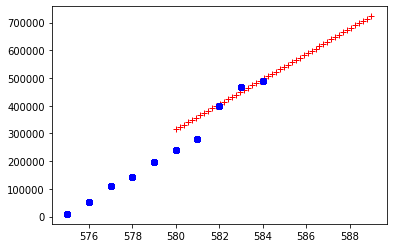

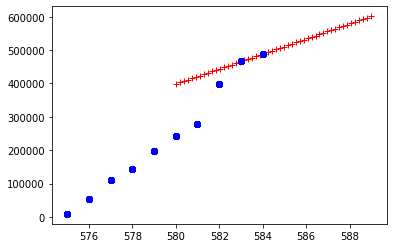

In [186]:
t = 121 # this is just to test individual reservoirs, like a random one from the list

#Split the dataframe into multiple dataframes, one for each reservoir
ID_array = np.unique(df.index)
ID_list = ID_array.tolist()

#use groupby() pandas function to group by unique values (ie by gauge ID)
data_list = []
grouped = df.groupby(df.index) 
for ID in ID_list:
    section = grouped.get_group(str(ID))
    data_list.append(section)

#Change the index to a zero base index for each reservoir (0 to n, like what it's default index would be)
data_list_reindex = []
for reservoir in data_list:
    df1 = reservoir.sort_values("Depth")
    df1 = df1.reset_index()
    data_list_reindex.append(df1)

#Have a look at the unedited surface area graph for the random reservoir you chose
test1 = data_list_reindex[t]
max_ = test1.index.max()
min_ = test1.index.min()

#Delete bad data
data_list2 = []
for n in data_list_reindex:
# This loop gets rid of datapoints if they show the surface area going down with depth, when it should go up
    obs_list = []

    for i, obs in n.iterrows():
        if i == 0: #We always put the first point in, even if it's bad (will fix later)
            obs_list.append(obs)
            continue
        if obs["Surface Area"] > obs_list[-1]["Surface Area"]: # if the number is bigger than the number before it, keep.
            obs_list.append(obs)

        obs_df = pd.DataFrame(obs_list)
    data_list2.append(obs_df)
test2 = data_list2[t]

max_2 = test2.index.max()
min_2 = test2.index.min()

#Fill gaps in depth and assign NaN surface area for those depths
test3 = test2.reindex(range(min_, max_+1))
test3['Depth'] = test1['Depth']
test3['ID'] = test1['ID']

#Interpolate
test4 = test3
test4['Surface Area'] = test3['Surface Area'].interpolate()
test4 = test4.head(max_2+1) #take off the end that's flatlining

#Take top 20% + 1 of data points 
x = list(test4['Depth'])
y = list(test4['Surface Area'])
length = len(x)
top20p = length*0.2
n_datapoints = round(top20p, 0) + 1
n_datapoints = int(n_datapoints)
test5 = test4.tail(n_datapoints)

top_x = list(test5['Depth'])
top_y = list(test5['Surface Area'])

print('GaugeID: ', test1.at[0, 'ID'])
print('Original index range = ', min_, 'to', max_)
print('Cleaned index range = ', min_2, 'to', max_2)
print('Top 20% + 1 data points = ', n_datapoints)

# Make a polynomial function to fit a curve to the datapoints
z = np.polyfit(top_x, top_y, 1) #use first degree polynomial
f = np.poly1d(z)
n_fit = len(f)
start = x[0]
stop = x[-1]
for x1 in np.linspace(start, stop):
    plt.plot(x, y, 'bo')
    plt.plot(x1+5, f(x1+5), 'r+')
    
plt.axis()
plt.show()

# Compare to fitting a line to the top 2 data points
test6 = test4.tail(2)
top_x = list(test6['Depth'])
top_y = list(test6['Surface Area'])
z = np.polyfit(top_x, top_y, 1)
f = np.poly1d(z)
n_fit = len(f)
start = x[0]
stop = x[-1]
for x1 in np.linspace(start, stop):
    plt.plot(x, y, 'bo')
    plt.plot(x1+5, f(x1+5), 'r+')
    
plt.axis()
plt.show()